In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from tslearn.clustering import TimeSeriesKMeans

pd.options.display.max_rows = 1000

In [15]:
df = pd.read_parquet('data/train_data.parquet')

I'll cluster this data by the nature of the increase in values (growth rate).

<Axes: >

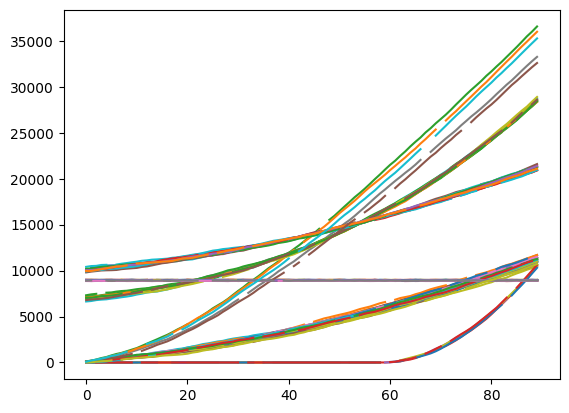

In [16]:
df.plot(legend=False)

Because all partners haven't outliers or sharp emissions and have a rather flat increase in the values there is possibility to fill NaN values by linear interpolation.

<Axes: >

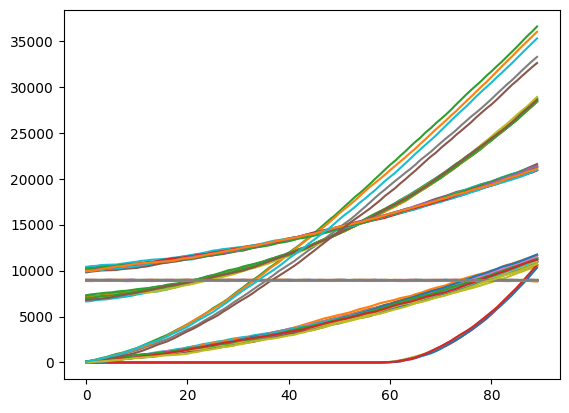

In [17]:
# Spline -> to fill last row correctly, not the same as previous
df = df.interpolate(method='spline', order=1).ffill().bfill()
df = df.apply(lambda x: np.where(x < 0, 0, x))
df.plot(legend=False)

Here is clearly visible 6 different growth rate clusters so let's cluster them)

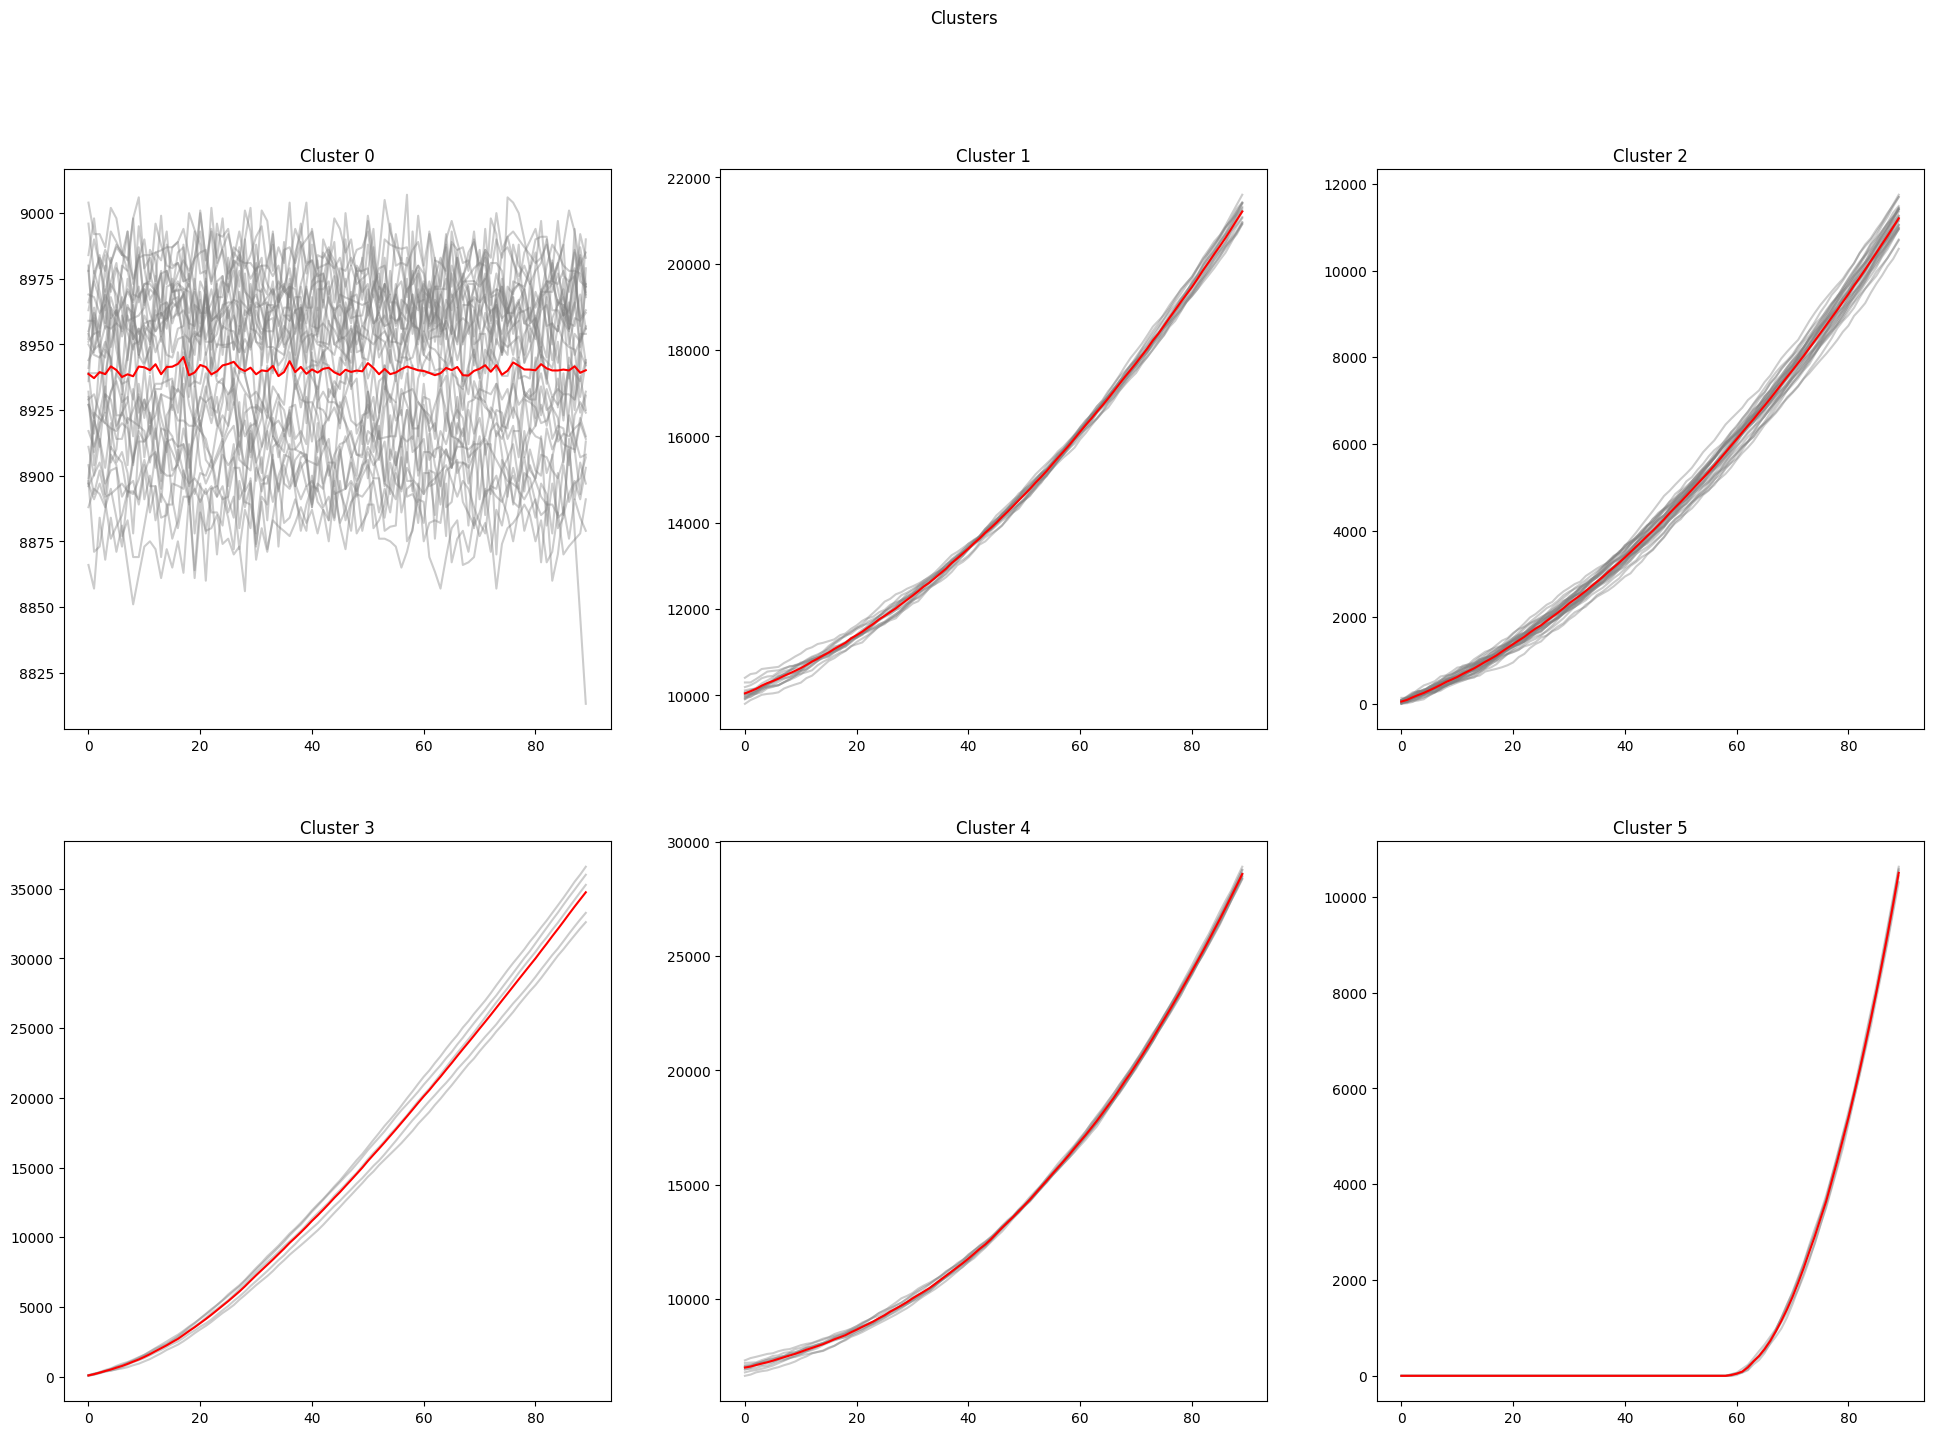

In [18]:
result_df_T = df.T
km = TimeSeriesKMeans(n_clusters=6)#, metric='dtw')
labels = km.fit_predict(result_df_T)

clusters_average_lines = {}

fig, ax = plt.subplots(2, 3, figsize=(24, 16))
fig.suptitle('Clusters')
row = 0
column = 0

for label in set(labels):
    cluster_name = f'Cluster {str(row * 3 + column)}'
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            ax[row, column].plot(result_df_T.iloc[i], c='gray', alpha=0.4)
            cluster.append(result_df_T.iloc[i])
    if len(cluster) > 0:
        clusters_average_lines[cluster_name] = np.average(np.vstack(cluster), axis=0)
        ax[row, column].plot(clusters_average_lines[cluster_name], color='r')
    ax[row, column].set_title(cluster_name)
    column += 1
    if column % 3 == 0:
        row += 1
        column = 0
plt.show()

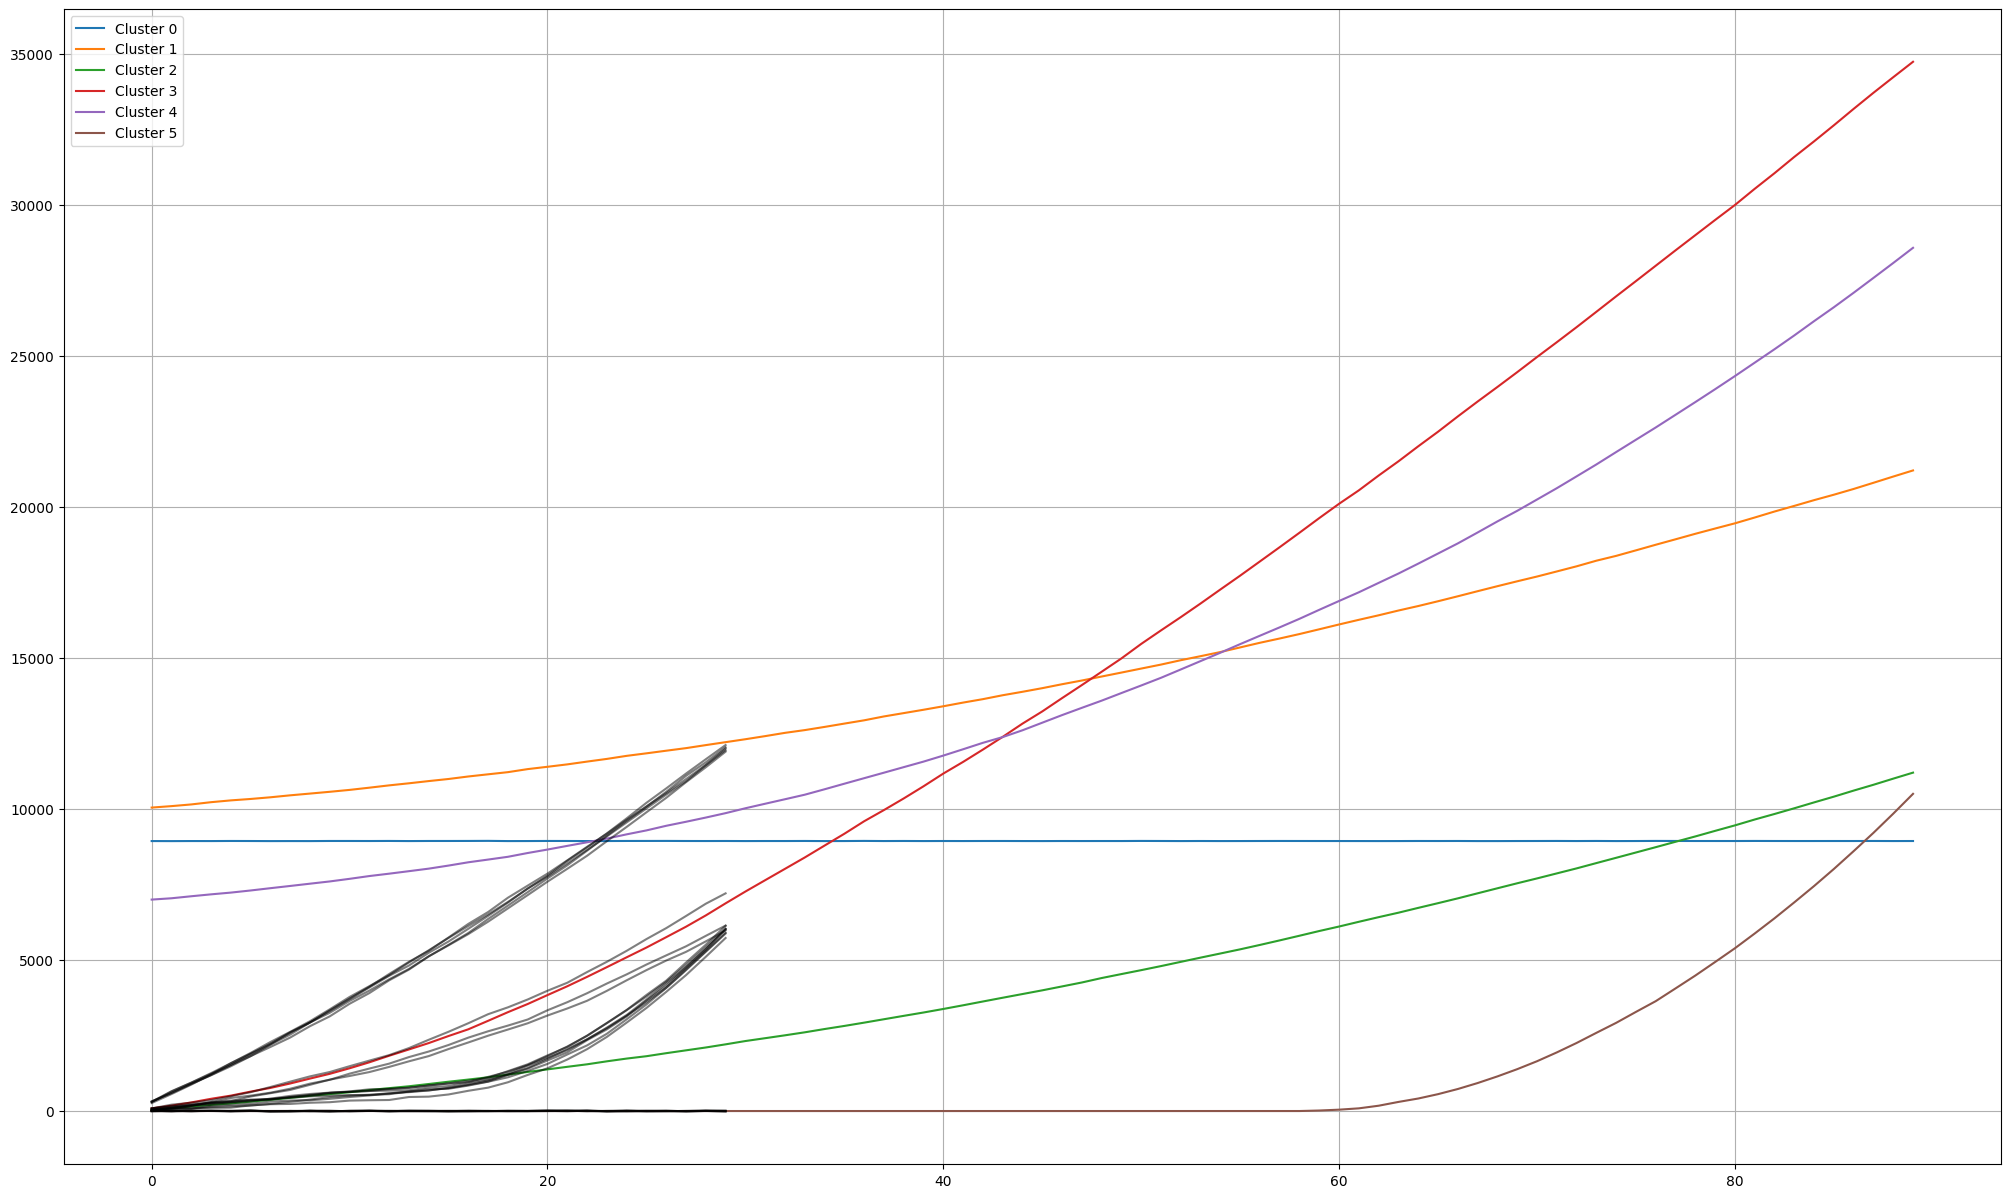

In [20]:
eval_df = pd.read_parquet('data/eval_data.parquet')

fig = plt.figure(figsize=(25,15))
for key in clusters_average_lines.keys():
    plt.plot(clusters_average_lines[key], label=key)
plt.plot(eval_df, c='black', alpha=0.5)
plt.legend()
plt.grid()
plt.show()

Get period of Cluster 5 after values start to growth, because there is 2 different growth rates. Second growth rate is zero, so partners from eval data that have zero growth rate will have Cluster 5.

Fit curve for the lines that starts not from 0 values, because data that should be clusterized starts from 0 values. This is not ultimate solution because data that should be clusterized could start not from 0 values, in that case in th dataset should be data points to understand if partner have 5000 value in 5th step from the beggining or in 50th.
b parameters = function argument when functions returns 0.

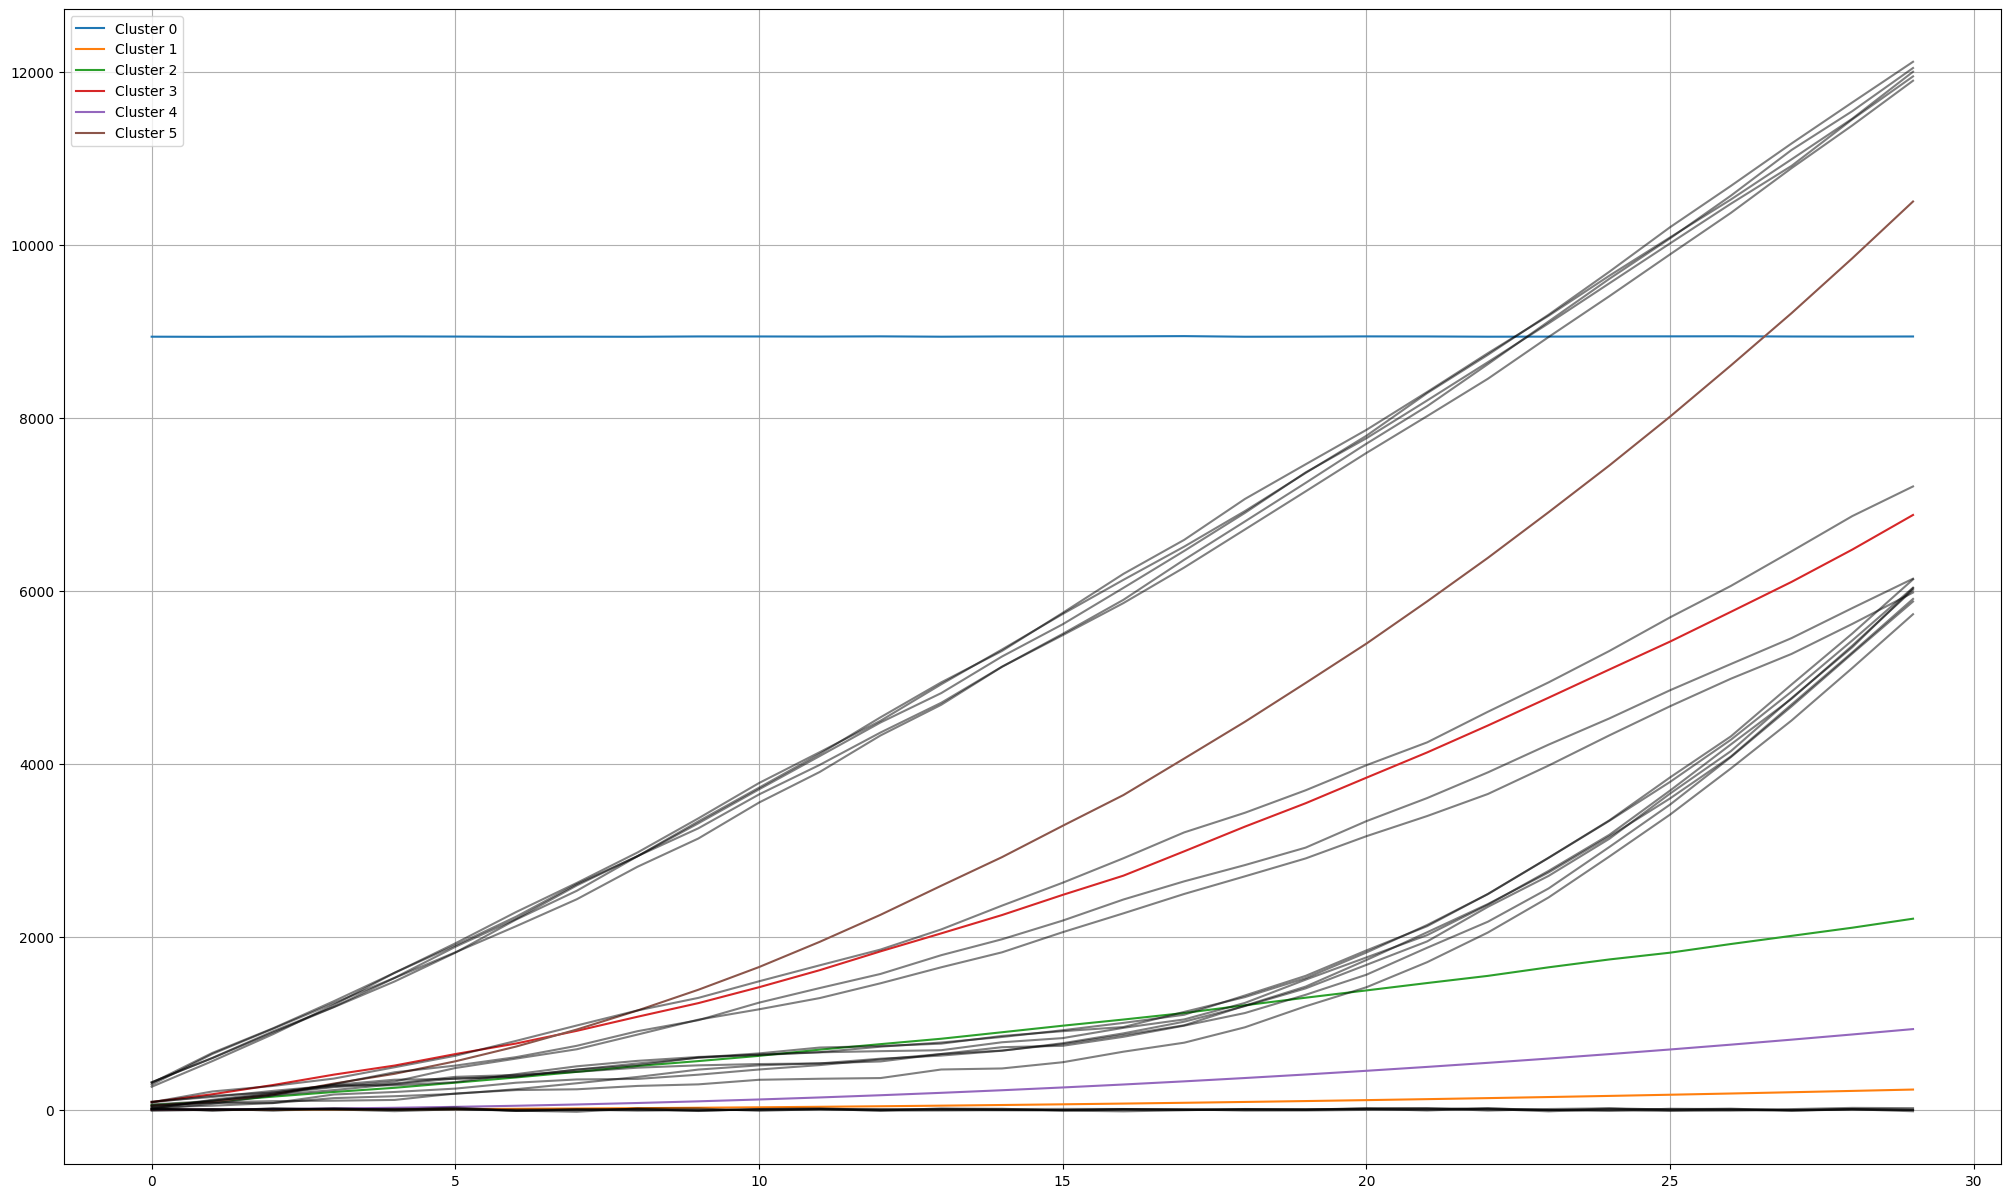

In [21]:
def func(x, a, b):
    return a * ((x + b) ** 2)

guess = (0.5, 0.5)
clusters_params = {}

for key in ['Cluster 1', 'Cluster 4']:
    x = [i for i in range(len(clusters_average_lines[key]))]
    params = curve_fit(func, x, clusters_average_lines[key], guess)[0]
    clusters_average_lines[key] = func([i for i in range(round(-params[1]), round(-params[1]) + 90)], *params)

fig = plt.figure(figsize=(25,15))
for key in clusters_average_lines.keys():
    line = clusters_average_lines[key]
    if (line == 0).sum() > 3:
        line = np.roll(line, -60)
        line = np.where(line == 0, np.nan, line)
        clusters_average_lines[key] = line
    plt.plot(line[:30], label=key)
plt.plot(eval_df, c='black', alpha=0.5)
plt.legend()
plt.grid()
plt.show()

Find for which cluster line each partners line is closest, distance measure - euclidian.

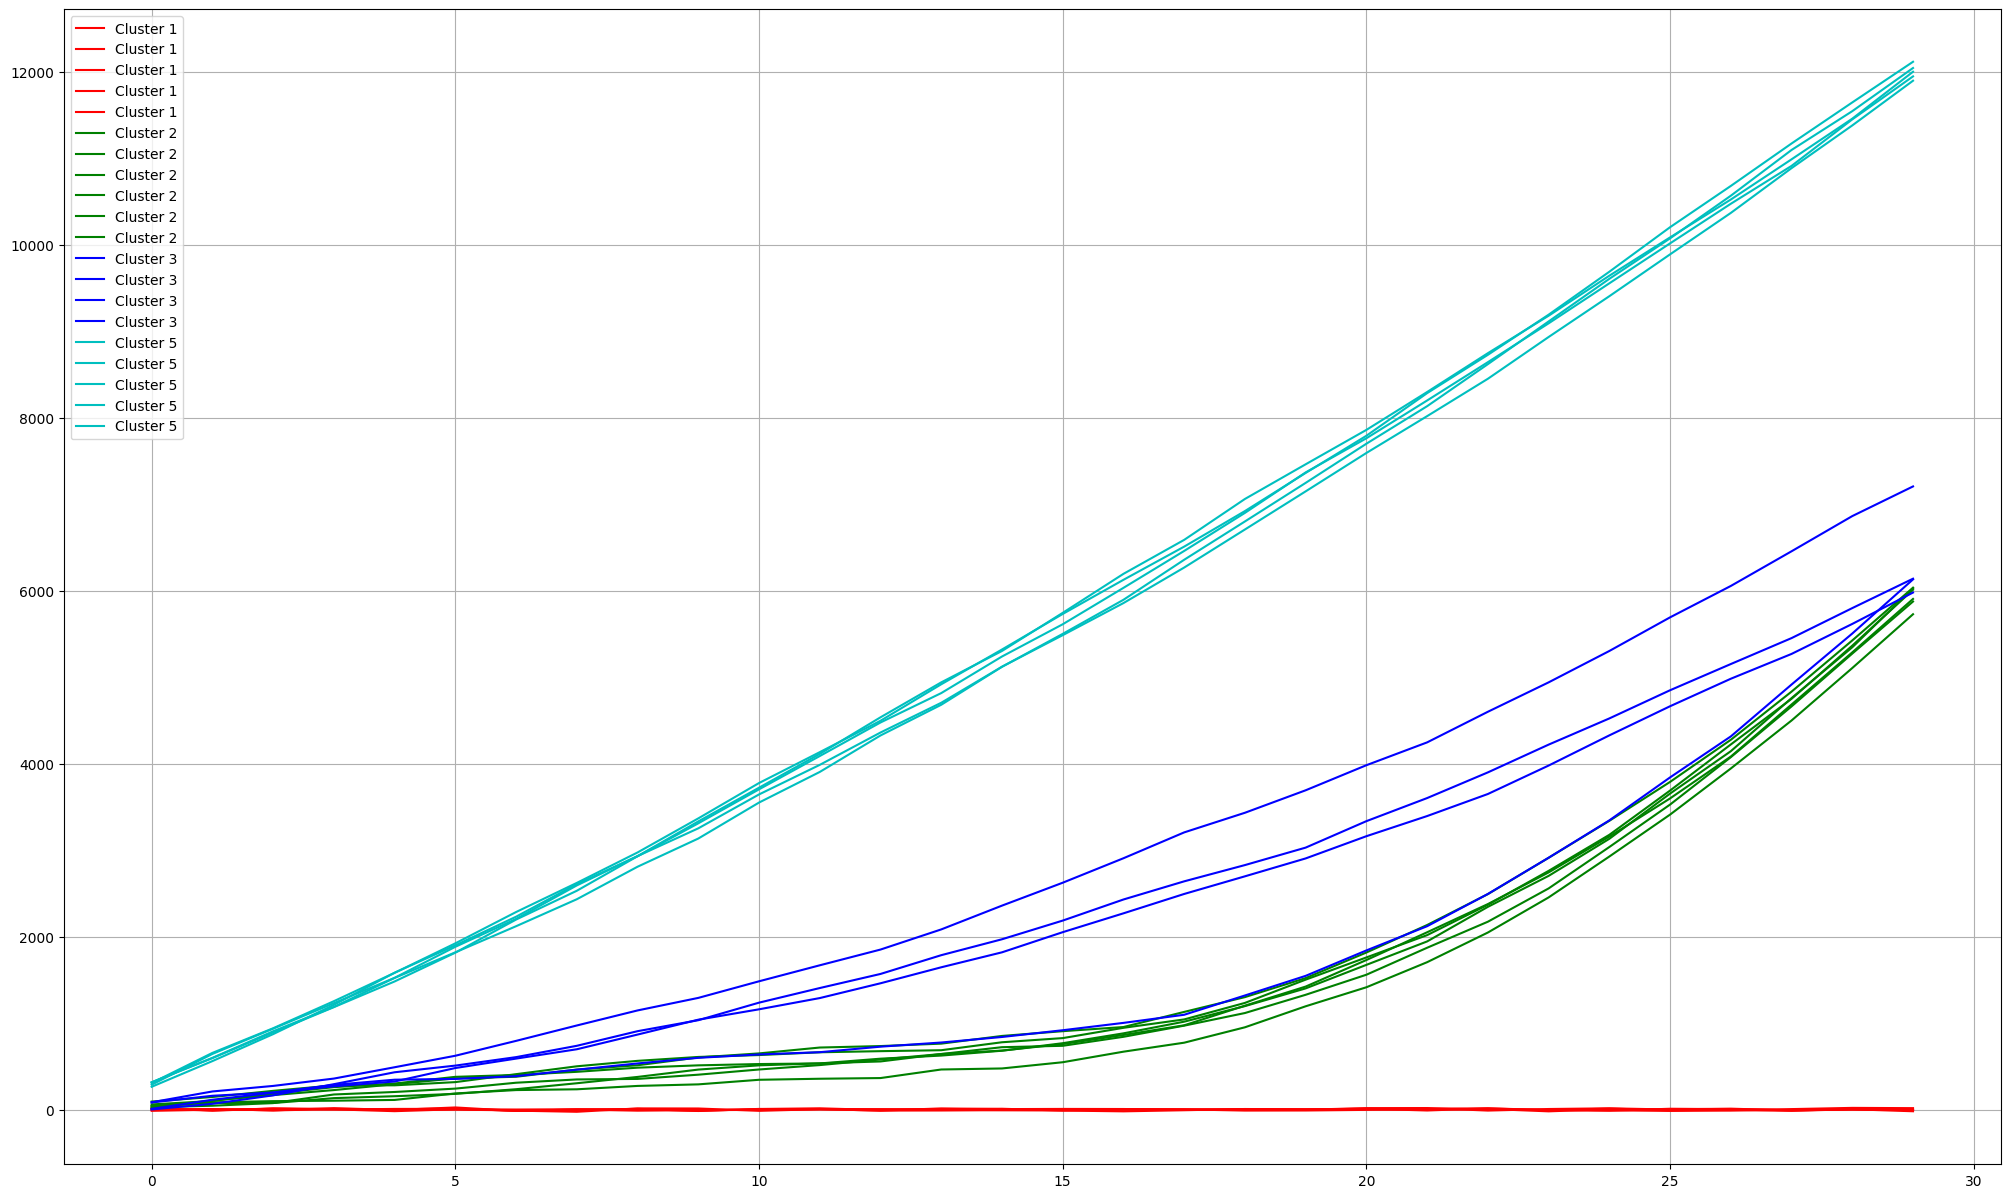

In [26]:
eval_clusters = {}
for col in eval_df.columns:
    min_distance = 1e100
    eval_clusters[col] = ''
    for key, line in clusters_average_lines.items():
        dist = ((eval_df[col] - line[:30]) ** 2).sum()
        if dist < min_distance:
            min_distance = dist
            eval_clusters[col] = key

fig = plt.figure(figsize=(25,15))
clusters_colors = ['r', 'g', 'b', 'c', 'm', 'y']
eval_clusters_transform = pd.DataFrame([eval_clusters]).T.groupby(by=[0]).groups
for i, key in enumerate(eval_clusters_transform.keys()):
    plt.plot(eval_df[eval_clusters_transform[key]], label=key, color=clusters_colors[i])
plt.legend()
plt.grid()
plt.show()

As I wrote earlier partners that have zero growth rate will be cluster to the Cluster 5.

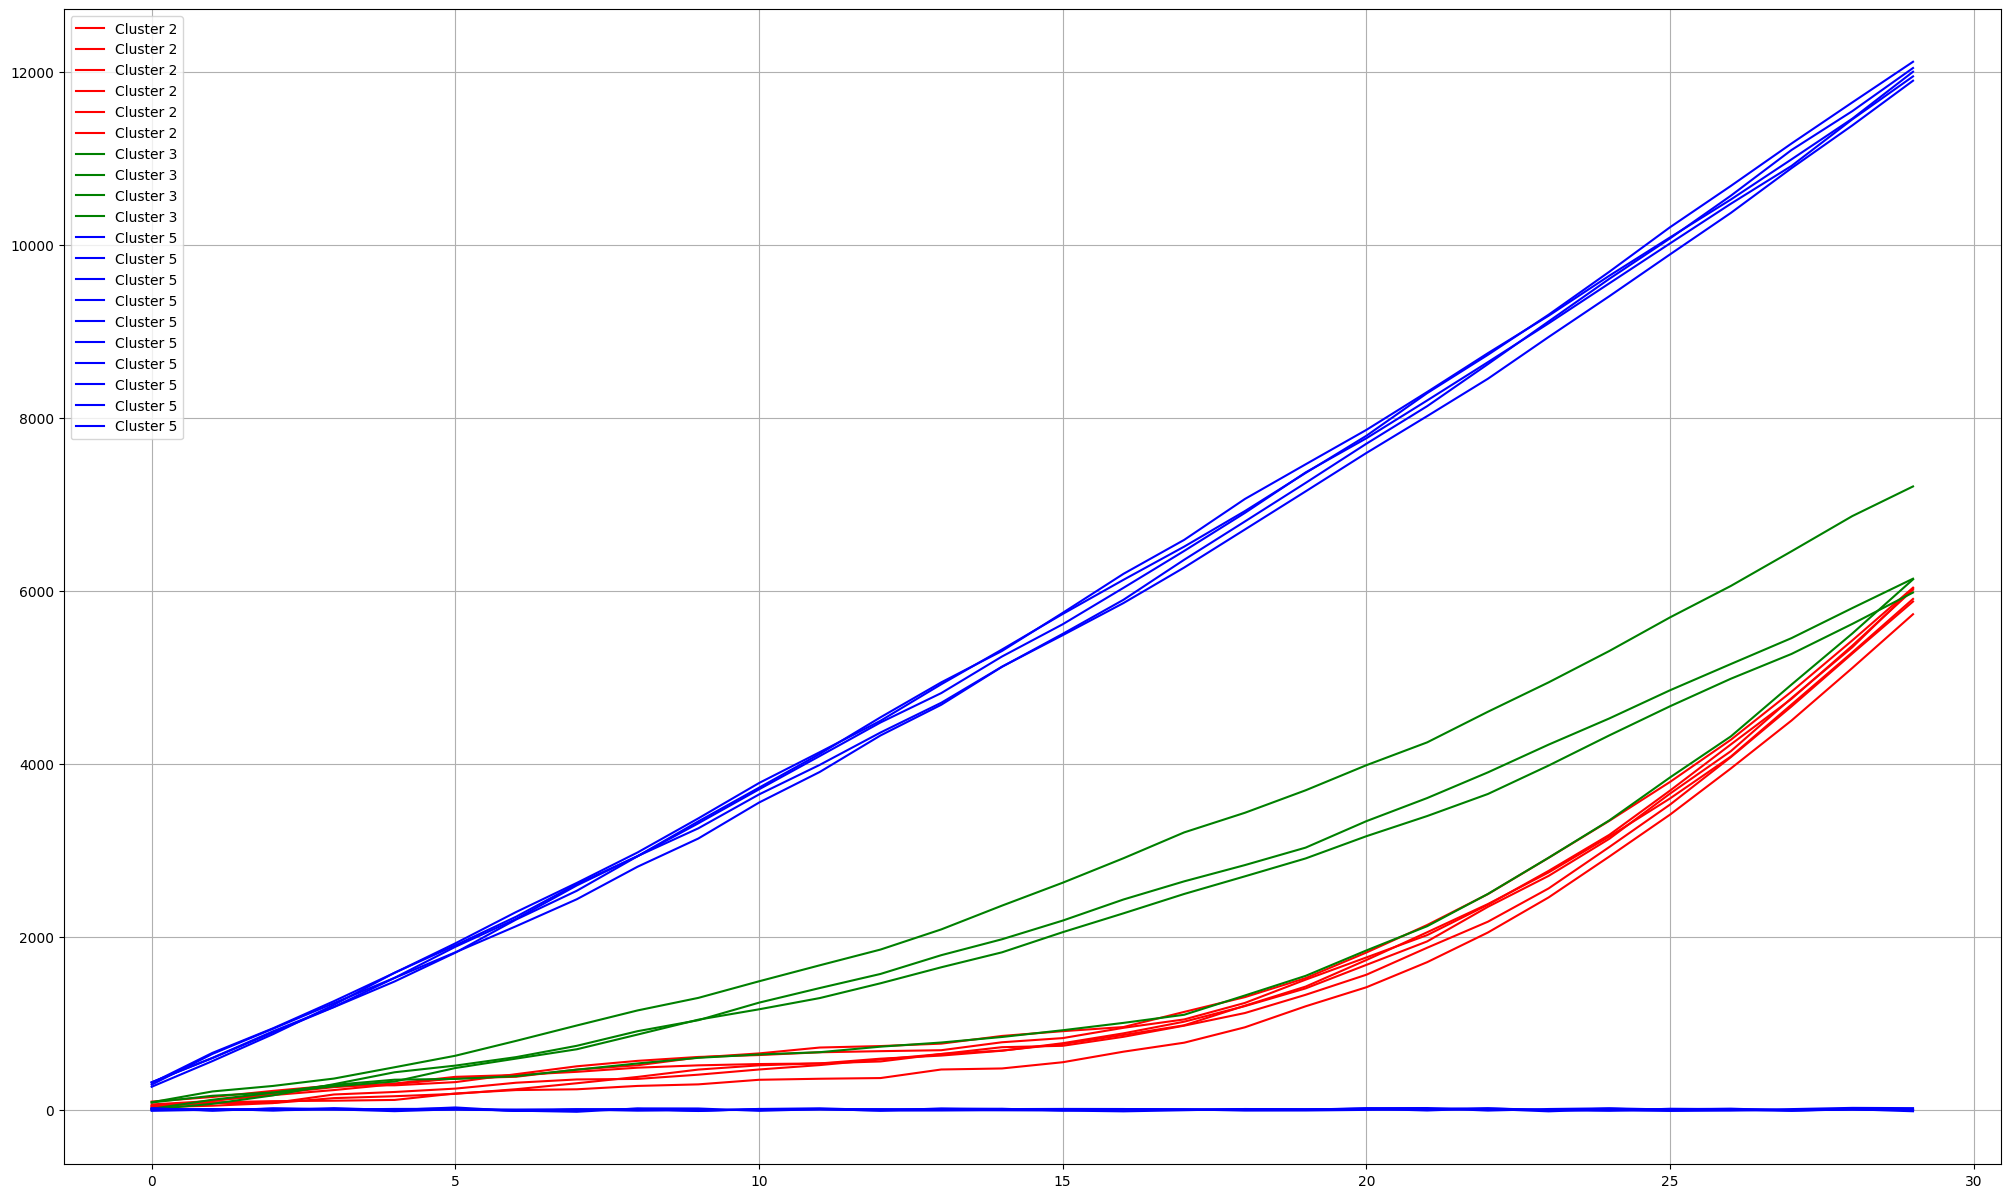

In [27]:
for key, value in eval_clusters.items():
    if value == 'Cluster 1':
        eval_clusters[key] = 'Cluster 5'

fig = plt.figure(figsize=(25,15))
clusters_colors = ['r', 'g', 'b', 'c', 'm', 'y']
eval_clusters_transform = pd.DataFrame([eval_clusters]).T.groupby(by=[0]).groups
for i, key in enumerate(eval_clusters_transform.keys()):
    plt.plot(eval_df[eval_clusters_transform[key]], label=key, color=clusters_colors[i])
plt.legend()
plt.grid()
plt.show()

Note: In the future Cluster 2 partners will be closer to the Cluster 5, because Cluster 2 partners have new data patter that doesn't fully fit any of the clusters from train data. But for now this partners closer to Cluster2 or Cluster 3.

In [28]:
result = pd.DataFrame([eval_clusters]).T.reset_index().rename(columns={'index': 'partnerID', 0: 'class'})
result['class'] = result['class'].str[-1]
result.to_csv('data/eval_data_classification.txt', index=False)